In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# %ls
# %cd C:\Users\KK\Downloads

C:\Users\KK\Downloads


In [3]:
file = pd.read_excel('test.xls')
file.head()

,Unnamed: 0,Rep.A,Data transakcji,Dzielnica,Obręb,Ulica,Nr bud.,Nr lok.,Kond.,P.u. [m2],...,Cena dodatkowych składników [zł],RAZEM,Cena jedn. razem [zł/m2],Izby,Opis,Rodzaj prawa do lokalu,Rodzaj rynku,Źródło danych,Data wpisu,Unnamed: 22
0,NaN,158,2018-01-08 00:00:00,Śródmieście,5-04-06,Tamka,22/24,36,2,10.3,...,NaN,82400.0,8000,1,NaN,NaN,wtórny,BGiKU m.st. Warszawy,maj 2018,NaN
1,NaN,21818,2020-08-06 00:00:00,Śródmieście,5-04-06,Tamka,22/24,12,1,11.39,...,NaN,130000.0,11413.5,1,NaN,własność,wtórny,BGiKU m.st. Warszawy,listopad 2020,NaN
2,NaN,24977,2020-08-27 00:00:00,Śródmieście,5-04-06,Tamka,22/24,12,1,11.39,...,NaN,175000.0,15364.4,1,NaN,własność,wtórny,BGiKU m.st. Warszawy,listopad 2020,NaN
3,NaN,2143,2019-03-21 00:00:00,Wola,6-01-05,Waliców,17,23,5,12.1,...,NaN,182000.0,15041.3,1,NaN,własność,wtórny,BGiKU m.st. Warszawy,wrzesień 2019,NaN
4,NaN,2678,2017-06-29 00:00:00,Śródmieście,5-02-08,Miodowa,20,13,4,13.48,...,NaN,100000.0,7418.4,2,Wa4M/00147202/3,NaN,wtórny,BGiKU m.st. Warszawy,sierpnień 2017,NaN


In [4]:
file.describe()

,RAZEM
count,4.963000e+03
mean,7.595548e+05
std,6.832976e+05
min,5.000000e+04
25%,4.150000e+05
50%,5.750000e+05
75%,8.300000e+05
max,1.320000e+07


In [5]:
file.dtypes

Unnamed: 0                           object
Rep.A                                object
Data transakcji                      object
 Dzielnica                           object
Obręb                                object
Ulica                                object
Nr bud.                              object
Nr lok.                              object
Kond.                                object
P.u.   [m2]                          object
Cena trans. [zł]                     object
Cena jedn. [zł/m2]                   object
Dodatkowe składniki                  object
Cena dodatkowych składników [zł]     object
RAZEM                               float64
Cena jedn. razem [zł/m2]             object
Izby                                 object
Opis                                 object
Rodzaj prawa do lokalu               object
Rodzaj rynku                         object
Źródło danych                        object
Data wpisu                           object
Unnamed: 22                     

In [6]:
raw = file.copy().drop(['Unnamed: 0', 'Rep.A', 'Obręb', 'Cena trans. [zł]', 
                       'Cena jedn. [zł/m2]','Cena dodatkowych składników [zł]',
                       'Cena jedn. razem [zł/m2]','Opis','Źródło danych','Data wpisu','Unnamed: 22'], axis = 1)

In [7]:
raw['Rodzaj prawa do lokalu'].unique()

array([nan, 'własność', 'swpl', 'spółdzielcze'], dtype=object)

In [8]:
raw.drop('Rodzaj prawa do lokalu', axis=1, inplace=True)

In [9]:
df = raw[raw['RAZEM'].notna()]
df = df[df['Izby'].notna()]

In [10]:
df['Data transakcji'] = pd.to_datetime(df['Data transakcji']) 

## Checking floor level and converting to 0/1 for non-groundfloor false/true

In [13]:
df['Kond.'].unique()

array([4, 5, 17, 10, 9, 6, 1, 2, 18, 3, 7, 8, 12, 15, 13, 11, 16, 14,
       'bd', 21, 20, nan, 'suterena', '17 (12 piętro)', 39, 22, 41, 24,
       '5 i 6', 28, 'antresola', '4 i 5', '4i5', '5i6',
       '9 kond (6 piętro)', 19, 42, 25, 'poddasze', 23,
       'półsuterena (kondygnacja dodatkowa)', 34, 33, 52, 36, 27, 45, 38,
       29, '7 i 8', '1', 32, 'brak danych, w KW też', '4 k(2p)', 'parter',
       '4 kond.(2piętro)', '4 + strych', '5 kodnygnacja, 2 piętro',
       '11 i 12', '8 i 9 k.', '3 i 4', 37, '13k (8 piętro)',
       '35k/30 piętro', 30, '2 i 3', 35], dtype=object)

In [14]:
df['Kond.'].loc[df['Kond.'] =='parter'] = 0
df['Kond.'].loc[df['Kond.'] =='półsuterena (kondygnacja dodatkowa)'] = 0
df['Kond.'].loc[df['Kond.'] =='suterena'] = 0

D:\Programowanie\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
df['Kond.'].loc[df['Kond.']!=0] = 1

## Creating full address column for geolocation

In [16]:
df['Full_address'] = df[df.columns[2:4]].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1)
df['Full_address'] = df['Full_address'].astype(str) + ', Warsaw, Poland'
df.head()

,Data transakcji,Dzielnica,Ulica,Nr bud.,Nr lok.,Kond.,P.u. [m2],Dodatkowe składniki,RAZEM,Izby,Rodzaj rynku,Full_address
0,2017-08-29,Śródmieście,29-go Listopada,3,14,1,27.78,NaN,220000,2,wtórny,"29-go Listopada 3, Warsaw, Poland"
2,2017-08-11,Śródmieście,Al. Armii Ludowej,6,105,1,50.87,NaN,540000,3,wtórny,"Al. Armii Ludowej 6, Warsaw, Poland"
3,2017-08-31,Śródmieście,Al. Jana Pawła II,80,86,1,49.9,NaN,560000,3,wtórny,"Al. Jana Pawła II 80, Warsaw, Poland"
4,2017-09-01,Śródmieście,Al. Jana Pawła II,80,20,1,52.5,mpgp,565000,2,wtórny,"Al. Jana Pawła II 80, Warsaw, Poland"
5,2017-09-07,Śródmieście,Al. Jana Pawła II,26,813,1,38.8,NaN,380000,2,wtórny,"Al. Jana Pawła II 26, Warsaw, Poland"


In [17]:
df1 = df.copy()

In [18]:
df1.head()

,Data transakcji,Dzielnica,Ulica,Nr bud.,Nr lok.,Kond.,P.u. [m2],Dodatkowe składniki,RAZEM,Izby,Rodzaj rynku,Full_address
0,2017-08-29,Śródmieście,29-go Listopada,3,14,1,27.78,NaN,220000,2,wtórny,"29-go Listopada 3, Warsaw, Poland"
2,2017-08-11,Śródmieście,Al. Armii Ludowej,6,105,1,50.87,NaN,540000,3,wtórny,"Al. Armii Ludowej 6, Warsaw, Poland"
3,2017-08-31,Śródmieście,Al. Jana Pawła II,80,86,1,49.9,NaN,560000,3,wtórny,"Al. Jana Pawła II 80, Warsaw, Poland"
4,2017-09-01,Śródmieście,Al. Jana Pawła II,80,20,1,52.5,mpgp,565000,2,wtórny,"Al. Jana Pawła II 80, Warsaw, Poland"
5,2017-09-07,Śródmieście,Al. Jana Pawła II,26,813,1,38.8,NaN,380000,2,wtórny,"Al. Jana Pawła II 26, Warsaw, Poland"


In [19]:
df1.drop(['Ulica','Nr bud.','Nr lok.'],axis=1, inplace=True)

## Checking for apartment extras and assigning 0/1

In [21]:
# 0 if there are no extra components, 1 if there are
df1['Dodatkowe składniki'].fillna(0)
df1['Dodatkowe składniki'].loc[df1['Dodatkowe składniki']!=0] = 1

D:\Programowanie\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Checking if it's a new building and assigning 0/1

In [22]:
df1['Rodzaj rynku'].unique()

array(['wtórny'], dtype=object)

In [23]:
# Rynek pierwotny - 1, rynek wtórny 0
df1['Rodzaj rynku'].loc[df1['Rodzaj rynku']=='wtórny'] = 0
df1['Rodzaj rynku'].loc[df1['Rodzaj rynku']!='wtórny'] = 1

In [26]:
df2 = df1.copy()
# df2['Izby'] == pd.to_numeric(df2['Izby'], 'coerce')

0       True
2       True
3       True
4       True
5       True
        ... 
4989    True
4990    True
4991    True
4992    True
4993    True
Name: Izby, Length: 4815, dtype: bool

In [27]:
df2.describe()

<ipython-input-27-77c0659fc2a8>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe()


,Data transakcji,Dzielnica,Kond.,P.u. [m2],Dodatkowe składniki,RAZEM,Izby,Rynek pierwotny,Full_address
count,4815,4815,4815.0,4815.0,4815.0,4815.0,4815.0,4815.0,4815
unique,1126,3,2.0,3016.0,1.0,1133.0,17.0,1.0,1516
top,2017-06-21 00:00:00,Śródmieście,1.0,26.7,1.0,500000.0,3.0,1.0,"Pokorna 2, Warsaw, Poland"
freq,14,4813,4809.0,36.0,4815.0,68.0,1750.0,4815.0,52
first,2017-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Changing date of sale to number of years between the sale and latest year

In [28]:
df2['Rok sprzedaży'] = df['Data transakcji'].dt.year
df2.drop('Data transakcji',axis=1,inplace=True)
cur_year = 2021
df2['Rok sprzedaży'] = df2['Rok sprzedaży'].apply(lambda x: cur_year - x)
df2.rename(columns={'Rok sprzedaży': "Sold_years_ago"}, inplace=True)

## Importing libraries and assigning geolocations to addresses

In [29]:
import geopy
from geopy.geocoders import Nominatim

In [30]:
locator = Nominatim(user_agent='KKGeocoder')

In [31]:
df2['Location'] = df2['Full_address'].apply(locator.geocode)

In [32]:
# commented out not to replace good file
# df2.to_csv('test_cleaned.csv')

In [112]:
# df3 = pd.read_csv('Downloads/test_cleaned.csv')
df3 = df2.copy()

## Extracting latitude and longitude from geolocation

In [113]:
df3['LatLon'] = df3['Location'].apply(lambda loc: tuple(loc.point) if loc else None)

In [114]:
df3.head()

,Dzielnica,Kond.,P.u. [m2],Dodatkowe składniki,RAZEM,Izby,Rynek pierwotny,Full_address,Rok sprzedaży,Location,LatLon
0,Śródmieście,1,27.78,1,220000,2,1,"29-go Listopada 3, Warsaw, Poland",2017,None,None
2,Śródmieście,1,50.87,1,540000,3,1,"Al. Armii Ludowej 6, Warsaw, Poland",2017,"(6, Aleja Armii Ludowej, Latawiec, Śródmieście...","(52.21865745, 21.021245980597904, 0.0)"
3,Śródmieście,1,49.9,1,560000,3,1,"Al. Jana Pawła II 80, Warsaw, Poland",2017,"(80, Aleja Jana Pawła II, Osiedle Stawki, Mura...","(52.2541215, 20.98471662915737, 0.0)"
4,Śródmieście,1,52.5,1,565000,2,1,"Al. Jana Pawła II 80, Warsaw, Poland",2017,"(80, Aleja Jana Pawła II, Osiedle Stawki, Mura...","(52.2541215, 20.98471662915737, 0.0)"
5,Śródmieście,1,38.8,1,380000,2,1,"Al. Jana Pawła II 26, Warsaw, Poland",2017,"(Żabka, 26, Aleja Jana Pawła II, Za Żelazną Br...","(52.2372785, 20.9972196, 0.0)"


## Importing library and calculating distance between the apartment and city center (subway station)

In [115]:
# !pip install haversine


In [37]:
import haversine as hs

In [116]:
metro_centrum_latlon = (52.133180, 21.002280)
df3['Distance_to_center_m'] = df3['LatLon'].apply(lambda loc: hs.haversine(loc[1:], metro_centrum_latlon) if loc else None)

In [119]:
df3.drop(['Location','LatLon', 'Full_address'],axis=1, inplace = True)

## Converting columns to numeric for regression

In [122]:
df3['Kond.'] = pd.to_numeric(df3['Kond.'],'coerce')
df3['Area'] = pd.to_numeric(df3['P.u.   [m2]'], 'coerce')
df3.drop('P.u.   [m2]',axis=1, inplace=True)
df3['RAZEM'] = pd.to_numeric(df3['RAZEM'],'coerce')
df3['Izby'] = pd.to_numeric(df3['Izby'],'coerce')
df3['Kond.'] = pd.to_numeric(df3['Kond.'],'coerce')
df3['New_building'] = pd.to_numeric(df3['Rodzaj'],'coerce')
df3.drop('Rodzaj rynku', axis=1, inplace=True)
df3['Extras'] = pd.to_numeric(df3['Dodatkowe składniki'],'coerce')
df3.drop('Dodatkowe składniki', axis=1, inplace=True)

In [123]:
df3['Suburb'] = df3[' Dzielnica']
df3.drop(' Dzielnica', axis=1, inplace=True)

In [124]:
df3.dtypes

Kond.                     int64
RAZEM                   float64
Izby                    float64
Sold_years_ago            int64
Distance_to_center_m    float64
Area                    float64
New_building              int64
Extras                    int64
Suburb                   object
dtype: object

In [125]:
df3.head()

,Kond.,RAZEM,Izby,Sold_years_ago,Distance_to_center_m,Area,New_building,Extras,Suburb
0,1,220000.0,2.0,4,NaN,27.78,1,1,Śródmieście
2,1,540000.0,3.0,4,3903.559481,50.87,1,1,Śródmieście
3,1,560000.0,3.0,4,3907.312664,49.90,1,1,Śródmieście
4,1,565000.0,2.0,4,3907.312664,52.50,1,1,Śródmieście
5,1,380000.0,2.0,4,3906.027994,38.80,1,1,Śródmieście


In [126]:
df3['Suburb'].unique()

array(['Śródmieście', 'Ochota', 'Wola'], dtype=object)

## Saving the work into csv file
### Given geopy heavy calculations

In [12]:
df3.to_csv('ready_to_preprocess')

NameError: name 'df3' is not defined

# Loading latest version for final preprocessing

In [107]:
df4 = pd.read_csv('ready_to_preprocess')

In [108]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import make_column_transformer


# transformer = make_column_transformer(
#     (MinMaxScaler(), 
#         ['Izby', 'Area','Sold_years_ago', 
#          'Distance_to_center_m']),
#     (OneHotEncoder(handle_unknown=['Suburb'])

## Checking for outliers

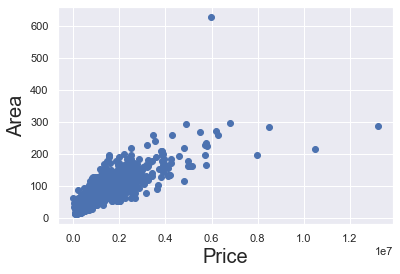

In [109]:
plt.scatter(df4['RAZEM'],df4['Area'])
plt.xlabel('Price', fontsize=20)
plt.ylabel('Area', fontsize=20)
plt.show()

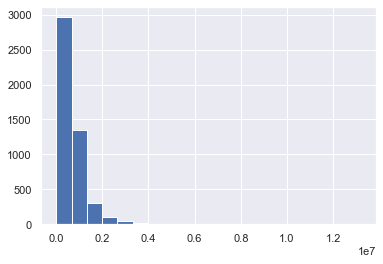

In [110]:
plt.hist(df4['RAZEM'], bins=20)
plt.show()

In [76]:
df4[df4['RAZEM']<5500000].shape[0]

4796

In [77]:
df4[df4['RAZEM']>=5500000].shape[0]

14

In [111]:
df4 = df4[df4['RAZEM']<5500000]

## Scaling and creating dummies 
### 3 options - StandardScaler or MinMaxScaler with suburb dummies or leave as is
### Run only 1 cell

## Option 1 StandardScaler

In [174]:
# # Scale (0 mean, std 1 => includes negatives)
# # to_std = df4[['Izby', 'Area', 'Sold_years_ago', 'Distance_to_center_m']]
# # scaled_inputs = pd.DataFrame(preprocessing.scale(to_std),columns=['Rooms','Area','Sold_years_ago','Distance_to_center_m'])
# # pre_shuffled_data = pd.concat([df4[['RAZEM','Kond.','Extras','New_building']],scaled_inputs,suburb_dummies],axis=1)
# #---------------------------------------------------------------------------------------
# suburb_dummies = pd.get_dummies(df4['Suburb'])
# #---------------------------------------------------------------------------------------
# to_std = df4[['Izby', 'Area', 'Sold_years_ago']] #test with less inputs
# scaled_inputs = pd.DataFrame(preprocessing.scale(to_std),columns=['Rooms','Area','Sold_years_ago'])
# pre_shuffled_data = pd.concat([df4[['RAZEM']],scaled_inputs],axis=1) #test with less inputs
# #---------------------------------------------------------------------------------------
# pre_shuffled_data.head()

,RAZEM,Rooms,Area,Sold_years_ago
0,220000.0,-0.789941,-0.945427,1.28597
1,540000.0,0.123113,-0.162004,1.28597
2,560000.0,0.123113,-0.194915,1.28597
3,565000.0,-0.789941,-0.106699,1.28597
4,380000.0,-0.789941,-0.571528,1.28597


## Option 2 MinMaxScaler

In [188]:
# # # MinMaxScaler (Between 0 and 1 => only non-negatives)
# scaler_1 = MinMaxScaler()
# #----------------------------------------------------------------------------------------
# # to_std = df4[['Izby', 'Area', 'Sold_years_ago', 'Distance_to_center_m']]
# # scaled_inputs = pd.DataFrame(scaler_1.fit_transform(to_std),columns=['Rooms','Area','Sold_years_ago','Distance_to_center_m'])
# # suburb_dummies = pd.get_dummies(df4['Suburb'])
# # pre_shuffled_data = pd.concat([df4[['RAZEM','Kond.','Extras','New_building']],scaled_inputs,suburb_dummies],axis=1)
# #----------------------------------------------------------------------------------------
# to_std = df4[['Izby', 'Area', 'Sold_years_ago']]
# scaled_inputs = pd.DataFrame(scaler_1.fit_transform(to_std),columns=['Rooms','Area','Sold_years_ago'])
# suburb_dummies = pd.get_dummies(df4['Suburb'])
# pre_shuffled_data = pd.concat([df4[['RAZEM']],scaled_inputs,suburb_dummies],axis=1)
# # pre_shuffled_data.head()

## Option 3 No change

In [244]:
# suburb_dummies = pd.get_dummies(df4['Suburb'])
# # pre_shuffled_data = df4[['RAZEM','Kond.','Extras','New_building','Izby','Area','Sold_years_ago','Distance_to_center_m']]
# -------------------------------------------------------------------------------------------------
pre_shuffled_data = df4[['RAZEM','Izby','Area','Sold_years_ago']] #test with less columns

## Filling NaNs for Distance to city center with average

In [130]:
avg_dist = pre_shuffled_data['Distance_to_center_m'].mean()
pre_shuffled_data['Distance_to_center_m'].fillna(avg_dist, inplace=True)
pre_shuffled_data.head()

KeyError: 'Distance_to_center_m'

## Dropping NaNs and converting to Numpy array

In [245]:
pre_shuffled_data.dropna(axis=0, inplace=True)

<ipython-input-245-ea3d5b12ebc7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_shuffled_data.dropna(axis=0, inplace=True)


In [246]:
pre_shuffled_data = pre_shuffled_data.to_numpy()
type(pre_shuffled_data)

numpy.ndarray

## Shuffling data

In [247]:
shuffled_indices = np.arange(pre_shuffled_data.shape[0])
np.random.shuffle(shuffled_indices)
shuffled_data = pre_shuffled_data[shuffled_indices]
shuffled_inputs = shuffled_data[:,1:]
shuffled_targets = shuffled_data[:,0]


## Splitting data between train, validation & test

In [248]:
samples_count = shuffled_inputs.shape[0]
train_samples_count = int(round(0.8*(samples_count),0))
val_samples_count = int(round(0.1*(samples_count),0))
test_samples_count = samples_count - train_samples_count - val_samples_count

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+val_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+val_samples_count]

test_inputs = shuffled_inputs[train_samples_count+val_samples_count:]
test_targets = shuffled_targets[train_samples_count+val_samples_count:]

In [249]:
train_targets[0:20]

array([ 210000.,  630000.,  440000., 3130000.,  547000.,  465000.,
        520000.,  557000.,  760000.,  350000.,  600000.,  236000.,
       1630000.,  745000.,  300000.,  480000.,  615000.,  400000.,
        480000.,  495000.])

In [250]:
np.count_nonzero(np.isnan(train_targets))

0

## Generating npz files and loading to variables

In [251]:
np.savez('data_train',inputs=train_inputs, targets=train_targets)
np.savez('data_val',inputs=validation_inputs, targets=validation_targets)
np.savez('data_test',inputs=test_inputs, targets=test_targets)

In [252]:
npz = np.load('data_train.npz')
train_inputs = npz['inputs'].astype(np.float)
train_targets = npz['targets'].astype(np.float)

npz = np.load('data_val.npz')
val_inputs = npz['inputs'].astype(np.float)
val_targets = npz['targets'].astype(np.float)

npz = np.load('data_test.npz')
test_inputs = npz['inputs'].astype(np.float)
test_targets = npz['targets'].astype(np.float)

In [253]:
test_targets.mean()
# train_targets.shape

751904.4125260961

## Setting up the model

In [254]:
input_size = 10
output_size = 1
hidden_layer_size = 250

model = tf.keras.Sequential([
        tf.keras.layers.Dense(input_size, activation='elu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='elu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='elu'),
    tf.keras.layers.Dense(output_size, activation='elu')
])


In [255]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Compiling and training the model

In [256]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

model.compile(
    loss=rmse,
    optimizer=Adam(learning_rate=0.0001),
    metrics=[rmse]
            )

batch_size = 1
max_epochs = 5

early_stopping = tf.keras.callbacks.EarlyStopping(patience=1)

model.fit(
         train_inputs, 
         train_targets,
         batch_size = batch_size,
         epochs = max_epochs,
         callbacks=[early_stopping],
         validation_data = (val_inputs, val_targets),
         verbose = 2
         )

Epoch 1/5
3833/3833 - 4s - loss: 478753.1562 - rmse: 478753.1562 - val_loss: 183802.1875 - val_rmse: 183802.1875 - 4s/epoch - 1ms/step
Epoch 2/5
3833/3833 - 4s - loss: 172946.3906 - rmse: 172946.3906 - val_loss: 181620.0469 - val_rmse: 181620.0469 - 4s/epoch - 981us/step
Epoch 3/5
3833/3833 - 4s - loss: 172381.9531 - rmse: 172381.9531 - val_loss: 180841.3594 - val_rmse: 180841.3594 - 4s/epoch - 974us/step
Epoch 4/5
3833/3833 - 4s - loss: 171832.5938 - rmse: 171832.5938 - val_loss: 181197.9688 - val_rmse: 181197.9688 - 4s/epoch - 978us/step


## Testing and evaluating the model

In [257]:
test_loss, test_accuracy = model.evaluate(train_inputs, train_targets)

120/120 [==============================] - 0s 1ms/step - loss: 307011.8750 - rmse: 306643.4688


In [242]:
predictions = model.predict(test_inputs)
predictions = np.ravel(predictions)
predictions[5:20]

array([1045051.2 ,  811895.7 ,  586007.44,  985645.06,  658507.3 ,
        599984.25,  799243.06,  809392.  , 1245181.2 ,  463591.62,
        328033.56,  651641.94,  869998.25,  512720.12,  646497.5 ],
      dtype=float32)

In [243]:
test_targets[5:20]

array([1235000.,  970000., 1090000., 1210000.,  550000.,  570000.,
        895000.,  799000., 1760000.,  528000.,  275000.,  520000.,
        818000.,  390000.,  675000.])